In [111]:
%load_ext autoreload
%autoreload 2

In [485]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPRegressor
import random

In [486]:
data_train = "Data_Train.csv"
data_test = "Data_Test.csv"

In [508]:
df = pd.read_csv("Data/" + data_train)
df_testing = pd.read_csv("Data/" + data_test)
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


Text variables : Title, sysnopsis

Categorical : Author, genre, bookCategory

composite (categorical) : Edition

real valued: Reviews, ratings

In [509]:
df.shape

(6237, 9)

In [510]:
def prepare_data(df):
    ''' cleaning data - fields Reviews, Ratings and Edtition'''
    
    df['Ratings'] = df.Ratings.str.split().str.get(0).str.replace(',', '').astype('int32')
    df['Reviews'] = df.Reviews.str.split().str.get(0).astype('float')
    df['Edition_type'] = df.Edition.str.split(',').str.get(0)
    df['Edition_year'] = df.Edition.str.split().str.get(-1)
    df = df.drop(columns=['Edition'])
    return df

In [511]:
df = prepare_data(df)
df.to_csv("Data/new_data.csv", index=None)
data = pd.read_csv("Data/new_data.csv")
data.head()

,Title,Author,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_type,Edition_year
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,2016
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,2012
2,Leviathan (Penguin Classics),Thomas Hobbes,4.8,6,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,1982
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,4.1,13,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,2017
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,5.0,1,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,2006


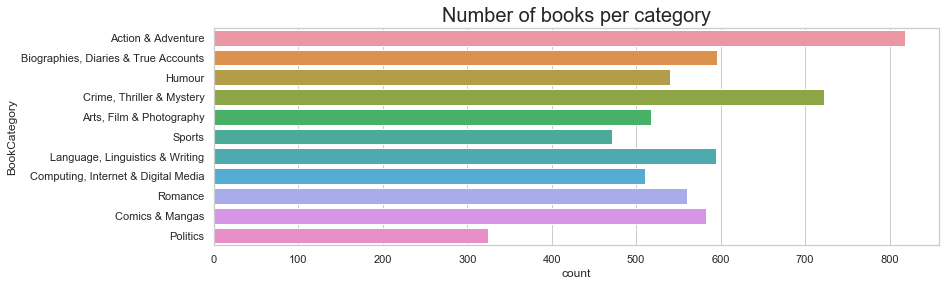

In [512]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="BookCategory", data=data).set_title("Number of books per category",fontsize=20)
plt.show()

Text(0.5, 1.0, 'Price of Books vs reviews')

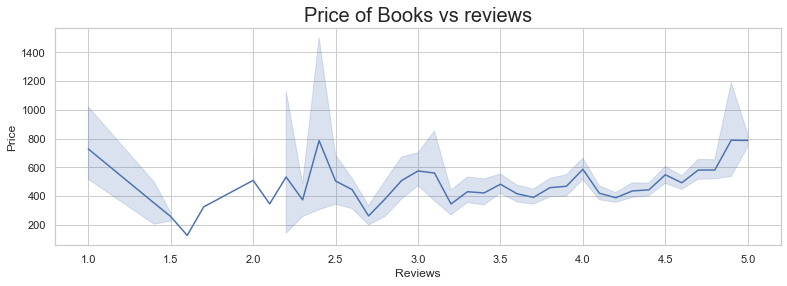

In [513]:
plt.figure(figsize=(13, 4))
sns.lineplot(x="Reviews", y="Price", data=data).set_title("Price of Books vs reviews",fontsize=20)

Text(0.5, 1.0, 'Price of Books vs No. of Ratings')

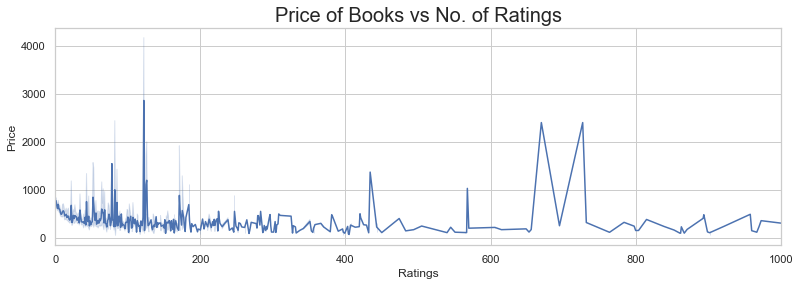

In [514]:
plt.figure(figsize=(13, 4))
ax = sns.lineplot(x="Ratings", y="Price", data=data)
ax.set_xlim([0,1000])
ax.set_title("Price of Books vs No. of Ratings",fontsize=20)

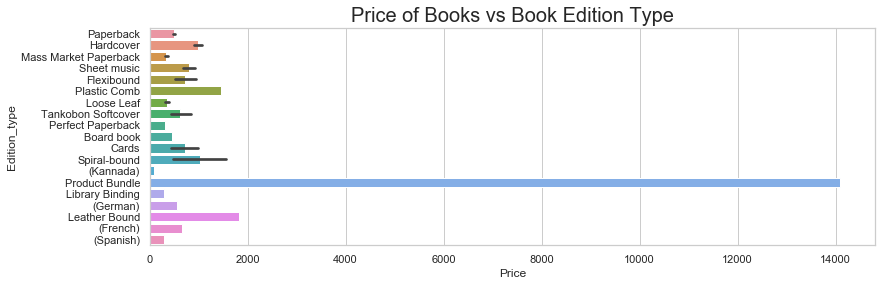

In [515]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.barplot(x="Price", y="Edition_type", data=data).set_title("Price of Books vs Book Edition Type",fontsize=20)
plt.show()

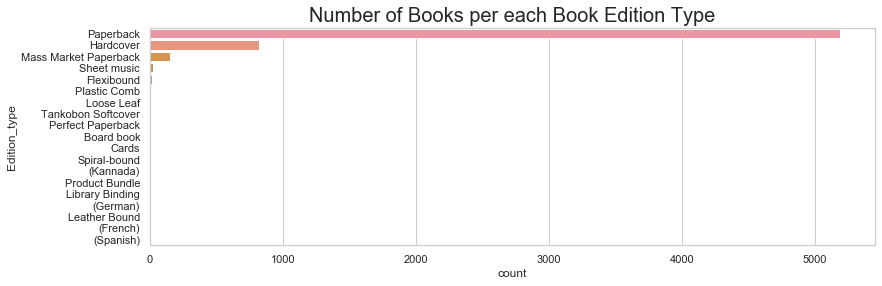

In [516]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="Edition_type", data=data).set_title("Number of Books per each Book Edition Type",fontsize=20)
plt.show()

(0, 25)

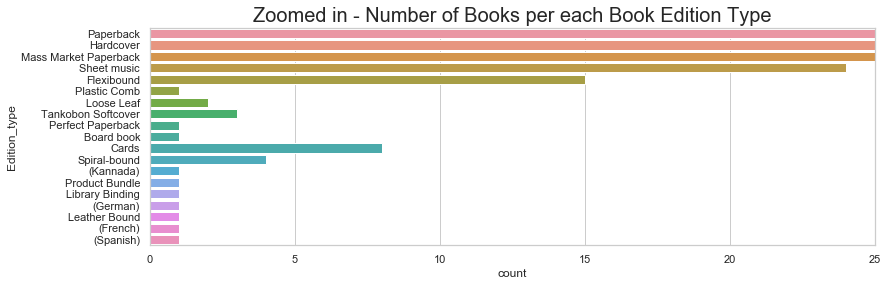

In [517]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="Edition_type", data=data).set_title("Zoomed in - Number of Books per each Book Edition Type",fontsize=20)
ax.set_xlim([0,25])

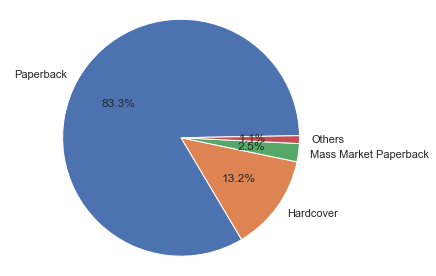

In [518]:
x = dict(data['Edition_type'].value_counts())
total = 0
for i, j in x.items():
    if j <= 24:
        total+=j
keys = [i for i, j in x.items() if j > 24]
keys.append("Others")
values = [j for i, j in x.items() if j > 24]
values.append(total)
labels = keys
sizes = values
# cs=cm.Set1(np.arange(len(values))/len(values))
# explode = [0]*len(values)
# plt.title("dsd")
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=1)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [519]:
data.shape

(6237, 10)

In [520]:
counts = pd.value_counts(data['Edition_type'])
mask = data['Edition_type'].isin(counts[counts > 24].index)
data['Edition_type'][~mask] = "Other_editions"
dummies = pd.get_dummies(data['Edition_type'])
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns=['Edition_type'])

In [530]:
counts = pd.value_counts(data['Genre'])
mask = data['Genre'].isin(counts[counts > 7].index)
data['Genre'][~mask] = "Other_genres"
dummies2 = pd.get_dummies(data['Genre'][mask])
data = pd.concat([data, dummies2], axis=1)
data = data.drop(columns=['Genre'])
data.shape

(6237, 119)

In [543]:
counts = pd.value_counts(data['Author'])
mask = data['Author'].isin(counts[counts > 2].index)
data['Author'][~mask] = "Other_authors"
dummies2 = pd.get_dummies(data['Author'][mask])
data = pd.concat([data, dummies2], axis=1)
data = data.drop(columns=['Author'])
data.shape
# dummies2.shape

(6237, 492)

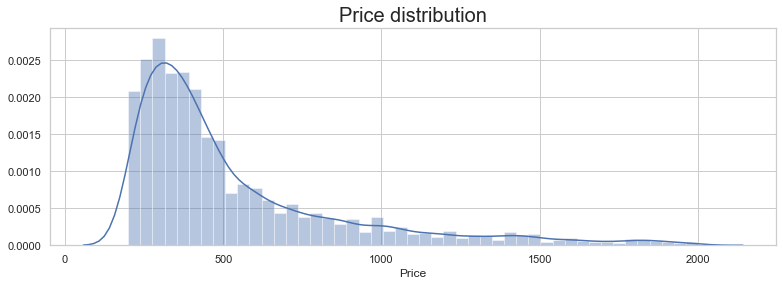

In [454]:
plt.figure(figsize=(13, 4))
sns.distplot(data['Price']).set_title("Price distribution", fontsize=20)
plt.show()

#### As we can see that the price distribution is a bit skewed, and there are several outliers as well.

In [381]:
# Removing outliers
data = data.loc[(data['Price'] <= 2000) & (data['Price'] >=200)]

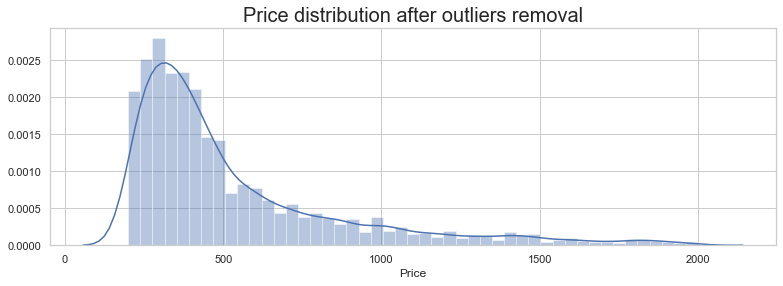

In [382]:
plt.figure(figsize=(13, 4))
sns.distplot(data['Price']).set_title("Price distribution after outliers removal", fontsize=20)
plt.show()

In [383]:
data.shape

(5090, 10)

### Add Synopsis as average word vectors to the features

In [80]:
stemmer = stem.PorterStemmer()
stop_words = stopwords.words('english')

def stem_stop(input_text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input_text.lower())
    tokens = [x for x in tokens if not x in stop_words]
    tokens_stemmed = [stemmer.stem(x) for x in tokens]
    return tokens_stemmed

def get_mean_vector(word2vec_model, words):
    words = [word for word in words if word in word2vec_model.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model[words], axis=0)
    else:
        return np.zeroes(300)

def get_word_vectors(df):
    sentences_train = list(df)
    sentences_train = [stem_stop(i) for i in sentences_train]
    sentences_train = np.array([get_mean_vector(model, i) for i in sentences_train])
    headers = ["Wordvec"+ str(i) for i in range(300)]
#     sentences_train = pd.DataFrame(data=sentences_train, columns=headers)
    return sentences_train


model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)
sentences = get_word_vectors(data['Synopsis'])
headers = ["Wordvec"+ str(i) for i in range(300)]
sentences = pd.DataFrame(data=sentences , index=data.index, columns=headers)
data = pd.concat([data, sentences], axis=1)

In [384]:
data = data.drop(columns=['Title', 'Synopsis'])
data.shape, data.columns

((5090, 8),
 Index(['Author', 'Reviews', 'Ratings', 'Genre', 'BookCategory', 'Price',
        'Edition_type', 'Edition_year'],
       dtype='object'))

In [385]:
Y = data['Price']
X = data.drop(columns=['Price'])

#### Using Binary encoding for categorical variables

In [386]:
ce_bin = ce.BinaryEncoder(cols = ['BookCategory','Edition_year', 'Genre','Author','Edition_type'])
X = ce_bin.fit_transform(X, Y)

In [387]:
X = normalize(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4072, 43), (1018, 43), (4072,), (1018,))

#### importing Decision tree regressor with max depth = 3

In [396]:
reg_model = DecisionTreeRegressor(max_depth=7)

reg_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [397]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

predictions = list(reg_model.predict(x_test))

print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Train error:  0.4371768903074914
Test error:  0.520501769737183


In [223]:
def plot_train_test_error(x_train, y_train, x_test, y_test, encoding_type):

    train_errors, test_errors, depths = [], [], []

    for depth in range(2, 30):
        reg_model = DecisionTreeRegressor(max_depth=depth)
        reg_model.fit(x_train, y_train)
        train_err = np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train)))
        test_err = np.sqrt(mean_squared_log_error(y_test, reg_model.predict(x_test)))
        train_errors.append(train_err)
        test_errors.append(test_err)
        depths.append(depth)

    d = pd.DataFrame({"train_error": train_errors, "test_error": test_errors, "depths": depths})

    builds = d['depths']
    y_stack = np.row_stack((d['train_error'], d['test_error'])) 
    fig = plt.figure(figsize=(12,5))
    fig.suptitle('Train test error with ' + encoding_type + ' encoded categorical Variables', fontsize=15)
    ax1 = fig.add_subplot(111)

    ax1.plot(builds, y_stack[0,:], label='Train error', color='c', marker='o')
    ax1.plot(builds, y_stack[1,:], label='Test error', color='g', marker='.')

    plt.xticks(builds)
    plt.xlabel('Depth')
    plt.ylabel('Error')

    handles, labels = ax1.get_legend_handles_labels()
    lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
    ax1.grid('on')

    plt.show()

#### Plot train test error for Decision tree regressor with varying max depths

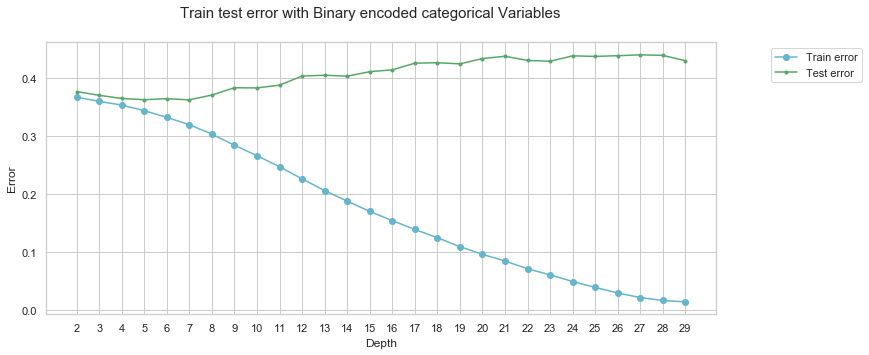

In [224]:
plot_train_test_error(x_train, y_train, x_test, y_test, 'Binary')

In [355]:
Y = data['Price']
X = data.drop(columns=['Price'])

#### Using one hot encoding for categorical variables

In [226]:
ce_bin = ce.OneHotEncoder(cols = ['BookCategory','Edition_year', 'Genre','Author','Edition_type'])
X = ce_bin.fit_transform(X, Y)

In [227]:
X = normalize(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3535, 3058), (884, 3058), (3535,), (884,))

#### importing Decision tree regressor with max depth = 3

In [228]:
reg_model = DecisionTreeRegressor(max_depth=3)

reg_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [229]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

predictions = list(reg_model.predict(x_test))

print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Train error:  0.36041400120046707
Test error:  0.3671667640630558


#### Plot train test error for Decision tree regressor with varying max depths

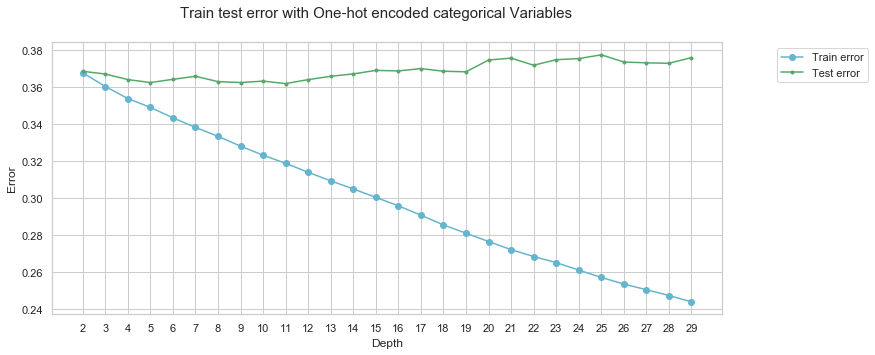

In [230]:
plot_train_test_error(x_train, y_train, x_test, y_test, 'One-hot')

we can see that model overfits badly as we increase the depth of tree.

#### Trying multi-layer perceptron regressor

In [356]:
reg_model = MLPRegressor(verbose=True, max_iter=6000, learning_rate_init=0.001, hidden_layer_sizes=(100, 3))

In [357]:
reg_model.fit(x_train, y_train)

Iteration 1, loss = 103471.82173003
Iteration 2, loss = 103089.61235370
Iteration 3, loss = 102553.19271775
Iteration 4, loss = 101763.25046294
Iteration 5, loss = 100629.09389408
Iteration 6, loss = 99112.22850863
Iteration 7, loss = 97152.70902928
Iteration 8, loss = 94757.06391147
Iteration 9, loss = 91859.95765703
Iteration 10, loss = 88463.35850741
Iteration 11, loss = 84542.00702081
Iteration 12, loss = 80118.56781000
Iteration 13, loss = 75214.20115191
Iteration 14, loss = 69933.22163073
Iteration 15, loss = 64346.14750119
Iteration 16, loss = 58619.28555761
Iteration 17, loss = 52849.48619799
Iteration 18, loss = 47201.59464290
Iteration 19, loss = 41777.21050872
Iteration 20, loss = 36717.95390650
Iteration 21, loss = 32154.39337054
Iteration 22, loss = 28094.28706166
Iteration 23, loss = 24652.98295403
Iteration 24, loss = 21870.15050744
Iteration 25, loss = 19651.20057138
Iteration 26, loss = 17990.31955491
Iteration 27, loss = 16806.79438468
Iteration 28, loss = 15943.52933

Iteration 234, loss = 12358.99944314
Iteration 235, loss = 12353.96248605
Iteration 236, loss = 12354.09772901
Iteration 237, loss = 12353.02397344
Iteration 238, loss = 12350.77963745
Iteration 239, loss = 12349.54539591
Iteration 240, loss = 12346.70725639
Iteration 241, loss = 12345.78004756
Iteration 242, loss = 12343.73650203
Iteration 243, loss = 12349.56494099
Iteration 244, loss = 12340.44827593
Iteration 245, loss = 12340.06068071
Iteration 246, loss = 12339.19975857
Iteration 247, loss = 12338.31401658
Iteration 248, loss = 12341.36079285
Iteration 249, loss = 12343.18579172
Iteration 250, loss = 12332.11348139
Iteration 251, loss = 12343.10050308
Iteration 252, loss = 12332.07006495
Iteration 253, loss = 12327.34444671
Iteration 254, loss = 12334.89621074
Iteration 255, loss = 12325.40245610
Iteration 256, loss = 12325.53443323
Iteration 257, loss = 12322.24891072
Iteration 258, loss = 12324.33748015
Iteration 259, loss = 12321.15592831
Iteration 260, loss = 12320.12657147
I

Iteration 460, loss = 12031.90590898
Iteration 461, loss = 12031.14500667
Iteration 462, loss = 12034.80908076
Iteration 463, loss = 12030.61184487
Iteration 464, loss = 12028.30195352
Iteration 465, loss = 12025.21507068
Iteration 466, loss = 12024.31967151
Iteration 467, loss = 12025.47653320
Iteration 468, loss = 12018.83313436
Iteration 469, loss = 12018.99422862
Iteration 470, loss = 12022.55410482
Iteration 471, loss = 12020.05516608
Iteration 472, loss = 12013.82632203
Iteration 473, loss = 12014.66844911
Iteration 474, loss = 12009.50642965
Iteration 475, loss = 12007.65166290
Iteration 476, loss = 12006.72964978
Iteration 477, loss = 12004.20216121
Iteration 478, loss = 12002.95690799
Iteration 479, loss = 12006.06342214
Iteration 480, loss = 12002.66102867
Iteration 481, loss = 11999.79425241
Iteration 482, loss = 11997.98052915
Iteration 483, loss = 11994.68666502
Iteration 484, loss = 11993.05178685
Iteration 485, loss = 11994.76791729
Iteration 486, loss = 11990.09810744
I

Iteration 687, loss = 11660.31303060
Iteration 688, loss = 11655.89317794
Iteration 689, loss = 11656.18462615
Iteration 690, loss = 11654.44659885
Iteration 691, loss = 11658.79321646
Iteration 692, loss = 11649.78297046
Iteration 693, loss = 11648.30822633
Iteration 694, loss = 11646.91992841
Iteration 695, loss = 11645.67397315
Iteration 696, loss = 11644.06022157
Iteration 697, loss = 11644.54745078
Iteration 698, loss = 11639.48120276
Iteration 699, loss = 11642.42789841
Iteration 700, loss = 11638.05295131
Iteration 701, loss = 11641.38605985
Iteration 702, loss = 11639.36585393
Iteration 703, loss = 11634.54301871
Iteration 704, loss = 11634.98468229
Iteration 705, loss = 11633.35303405
Iteration 706, loss = 11629.30293436
Iteration 707, loss = 11630.44798696
Iteration 708, loss = 11621.70024254
Iteration 709, loss = 11621.23236399
Iteration 710, loss = 11621.14815021
Iteration 711, loss = 11617.00190462
Iteration 712, loss = 11624.36331880
Iteration 713, loss = 11630.00107821
I

Iteration 911, loss = 11304.45746412
Iteration 912, loss = 11311.68599112
Iteration 913, loss = 11303.56655924
Iteration 914, loss = 11303.47679074
Iteration 915, loss = 11305.73428686
Iteration 916, loss = 11296.15553419
Iteration 917, loss = 11306.39118070
Iteration 918, loss = 11295.83492470
Iteration 919, loss = 11299.81087537
Iteration 920, loss = 11295.71493888
Iteration 921, loss = 11298.81351853
Iteration 922, loss = 11300.67321616
Iteration 923, loss = 11287.90746819
Iteration 924, loss = 11291.52889967
Iteration 925, loss = 11293.15976279
Iteration 926, loss = 11285.52763656
Iteration 927, loss = 11284.62814920
Iteration 928, loss = 11280.92099776
Iteration 929, loss = 11281.42081591
Iteration 930, loss = 11278.71461076
Iteration 931, loss = 11282.56251153
Iteration 932, loss = 11273.66977621
Iteration 933, loss = 11273.33828567
Iteration 934, loss = 11272.84376938
Iteration 935, loss = 11273.50819944
Iteration 936, loss = 11275.32690483
Iteration 937, loss = 11265.50299744
I

Iteration 1133, loss = 11014.01716022
Iteration 1134, loss = 11017.50676124
Iteration 1135, loss = 11020.81088767
Iteration 1136, loss = 11006.65954814
Iteration 1137, loss = 11007.80454799
Iteration 1138, loss = 11007.54512489
Iteration 1139, loss = 11005.77116300
Iteration 1140, loss = 11007.67344844
Iteration 1141, loss = 11010.85342885
Iteration 1142, loss = 10997.93525571
Iteration 1143, loss = 10998.34530614
Iteration 1144, loss = 10996.26504397
Iteration 1145, loss = 10998.31591867
Iteration 1146, loss = 11006.79270321
Iteration 1147, loss = 11000.50212385
Iteration 1148, loss = 11003.21733657
Iteration 1149, loss = 10998.92425860
Iteration 1150, loss = 10994.31390675
Iteration 1151, loss = 10987.29552794
Iteration 1152, loss = 10995.68042896
Iteration 1153, loss = 10989.43806937
Iteration 1154, loss = 10987.95219215
Iteration 1155, loss = 10985.94740646
Iteration 1156, loss = 10986.99297843
Iteration 1157, loss = 10985.45447487
Iteration 1158, loss = 10982.07695716
Iteration 11

Iteration 1351, loss = 10808.20964020
Iteration 1352, loss = 10805.01806292
Iteration 1353, loss = 10804.64973647
Iteration 1354, loss = 10806.47789819
Iteration 1355, loss = 10804.11651395
Iteration 1356, loss = 10815.44363652
Iteration 1357, loss = 10801.98400709
Iteration 1358, loss = 10802.19440636
Iteration 1359, loss = 10799.74543080
Iteration 1360, loss = 10800.04173796
Iteration 1361, loss = 10800.44205339
Iteration 1362, loss = 10795.96076504
Iteration 1363, loss = 10792.46528694
Iteration 1364, loss = 10793.81291505
Iteration 1365, loss = 10794.67095452
Iteration 1366, loss = 10793.00185055
Iteration 1367, loss = 10796.32914525
Iteration 1368, loss = 10810.09667093
Iteration 1369, loss = 10793.60969849
Iteration 1370, loss = 10788.56674821
Iteration 1371, loss = 10790.99886532
Iteration 1372, loss = 10792.54906856
Iteration 1373, loss = 10800.99072024
Iteration 1374, loss = 10787.73644221
Iteration 1375, loss = 10786.75190808
Iteration 1376, loss = 10791.35726393
Iteration 13

Iteration 1567, loss = 10647.82220975
Iteration 1568, loss = 10645.74117035
Iteration 1569, loss = 10645.73185702
Iteration 1570, loss = 10647.51783712
Iteration 1571, loss = 10641.54655899
Iteration 1572, loss = 10637.01593604
Iteration 1573, loss = 10635.64136201
Iteration 1574, loss = 10639.72094799
Iteration 1575, loss = 10643.04160989
Iteration 1576, loss = 10638.63402410
Iteration 1577, loss = 10633.34522403
Iteration 1578, loss = 10639.27696873
Iteration 1579, loss = 10632.37200399
Iteration 1580, loss = 10632.88972423
Iteration 1581, loss = 10630.18516718
Iteration 1582, loss = 10633.70482078
Iteration 1583, loss = 10631.15283856
Iteration 1584, loss = 10631.21379582
Iteration 1585, loss = 10626.45294499
Iteration 1586, loss = 10625.23103568
Iteration 1587, loss = 10629.00055658
Iteration 1588, loss = 10625.71838774
Iteration 1589, loss = 10624.41729518
Iteration 1590, loss = 10623.69693689
Iteration 1591, loss = 10623.20445759
Iteration 1592, loss = 10627.77600721
Iteration 15

Iteration 1789, loss = 10503.64950036
Iteration 1790, loss = 10506.73035705
Iteration 1791, loss = 10482.47781708
Iteration 1792, loss = 10486.45223030
Iteration 1793, loss = 10487.11690457
Iteration 1794, loss = 10484.43446522
Iteration 1795, loss = 10493.92842977
Iteration 1796, loss = 10483.51482577
Iteration 1797, loss = 10487.52858619
Iteration 1798, loss = 10481.18865069
Iteration 1799, loss = 10478.49604149
Iteration 1800, loss = 10481.19389780
Iteration 1801, loss = 10480.34676771
Iteration 1802, loss = 10476.94041349
Iteration 1803, loss = 10474.15222510
Iteration 1804, loss = 10476.53883490
Iteration 1805, loss = 10480.76157258
Iteration 1806, loss = 10470.65277264
Iteration 1807, loss = 10472.62710408
Iteration 1808, loss = 10474.56584527
Iteration 1809, loss = 10481.67211727
Iteration 1810, loss = 10476.38462476
Iteration 1811, loss = 10473.99623607
Iteration 1812, loss = 10472.34700087
Iteration 1813, loss = 10468.15628838
Iteration 1814, loss = 10468.16264319
Iteration 18

Iteration 2008, loss = 10351.70672347
Iteration 2009, loss = 10351.16278874
Iteration 2010, loss = 10349.36175487
Iteration 2011, loss = 10351.16714119
Iteration 2012, loss = 10351.89736517
Iteration 2013, loss = 10358.93838197
Iteration 2014, loss = 10347.54139072
Iteration 2015, loss = 10348.12956011
Iteration 2016, loss = 10353.44249529
Iteration 2017, loss = 10345.93885409
Iteration 2018, loss = 10351.50159570
Iteration 2019, loss = 10342.79383277
Iteration 2020, loss = 10343.71081853
Iteration 2021, loss = 10342.40831173
Iteration 2022, loss = 10338.43576606
Iteration 2023, loss = 10346.91661482
Iteration 2024, loss = 10340.05088351
Iteration 2025, loss = 10342.19761638
Iteration 2026, loss = 10342.16977417
Iteration 2027, loss = 10340.12700031
Iteration 2028, loss = 10339.98671477
Iteration 2029, loss = 10343.89266192
Iteration 2030, loss = 10340.62952220
Iteration 2031, loss = 10335.86009769
Iteration 2032, loss = 10336.07266702
Iteration 2033, loss = 10335.42122030
Iteration 20

Iteration 2225, loss = 10234.09111862
Iteration 2226, loss = 10232.17134654
Iteration 2227, loss = 10243.47053085
Iteration 2228, loss = 10234.85645240
Iteration 2229, loss = 10225.92829776
Iteration 2230, loss = 10224.69994938
Iteration 2231, loss = 10222.24088069
Iteration 2232, loss = 10220.26493573
Iteration 2233, loss = 10222.72909401
Iteration 2234, loss = 10222.32096238
Iteration 2235, loss = 10236.93008276
Iteration 2236, loss = 10229.67004970
Iteration 2237, loss = 10226.58080408
Iteration 2238, loss = 10224.53886494
Iteration 2239, loss = 10223.69862117
Iteration 2240, loss = 10228.34261182
Iteration 2241, loss = 10217.96101389
Iteration 2242, loss = 10217.36334440
Iteration 2243, loss = 10219.89247882
Iteration 2244, loss = 10220.50965612
Iteration 2245, loss = 10217.99833523
Iteration 2246, loss = 10219.95438343
Iteration 2247, loss = 10212.38765607
Iteration 2248, loss = 10214.62999956
Iteration 2249, loss = 10213.40213506
Iteration 2250, loss = 10210.65967887
Iteration 22

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 3), learning_rate='constant',
             learning_rate_init=0.001, max_iter=6000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [358]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

Train error:  0.32603547175641395


In [359]:
predictions = list(reg_model.predict(x_test))

In [360]:
print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Test error:  0.35949382204333247


In [364]:
# y_test = list(y_test)
# z = zip(y_test, predictions)
# z = random.sample(list(z), 200)

# z1 = [i[0] for i in z]
# z2 = [i[1] for i in z]

# plt.figure(figsize=(20, 20))
# ax = sns.lineplot(x=z1, y=z2)
# ax.set_xlim([0,1500])
# ax.set_ylim([0,1500])
# ax.set_title("labels comaprison",fontsize=20)